## Encoder-Decoder Architecture

In [1]:
%matplotlib inline 

# Basics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

# Keras
import keras
import keras.backend as K
from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, Lambda, UpSampling2D
from keras.layers import Dropout, BatchNormalization, multiply, dot

# Others
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/Users/Junior/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
# Load Dataset
# df=pd.read_msgpack('MREdata_102418.msg')
df=pd.read_msgpack('Test_CDPhantom1.msg')

In [9]:
# Prepare Data
Ur = np.stack(df.Ur.values,axis=3).transpose(3,0,1,2)
Ui = np.stack(df.Ui.values,axis=3).transpose(3,0,1,2)
x_data = np.sqrt(Ui**2+Ur**2)

y_data = np.stack(df.RS.values,axis=2).transpose(2,0,1)
y_data = y_data/10000.

print 'X size:', x_data.shape
print 'Y size:', y_data.shape

X size: (43, 64, 64, 3)
Y size: (43, 64, 64)


In [ ]:
# Split to Train & Valid
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data,test_size=0.3)
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,test_size=0.2)

print 'Training examples:   ', len(x_train)
print 'Validation examples: ', len(x_valid)
print 'Testing examples:    ', len(x_test)

## Building Neural Network

### Dual Objective
We want to use a secondary objective function based on the expression:
$$\nabla \cdot(\mu (\nabla u + \nabla u^\intercal)) + \nabla(\lambda \cdot u)  = - \omega \rho u$$

A possible matrix simplification could be:
$$\mu \cdot u\prime\prime + \lambda \cdot u\prime\prime = - \omega\rho u$$

A simpler objective that we can use is:
$$\mu\nabla^2u = -\omega \rho u$$


In [ ]:
# def laplace(x):
#     # Make Kernel
#     a = np.asarray([[0., 1., 0.],
#                     [1.,-4., 1.],
#                     [0., 1., 0.]])    
# #     a = np.asarray([[0.5, 1.0, 0.5],
# #                     [1.0, -6., 1.0],
# #                     [0.5, 1.0, 0.5]])
#     a = a.reshape(list(a.shape) + [1,1])
#     kernel = K.constant(a,dtype=1)
    
#     # Do Convolution
#     x = K.expand_dims(K.expand_dims(x, 0), -1)
#     y = K.depthwise_conv2d(x,kernel, padding='same')
    
#     return y[0,:,:,0]

# def laplacian(x):
#     u = K.tf.norm(x,axis=3)
#     return K.map_fn(laplace,u)

# def laplacian3D(x):
#     u1 = K.map_fn(laplace,x[:,:,:,0])
#     u2 = K.map_fn(laplace,x[:,:,:,1])
#     u3 = K.map_fn(laplace,x[:,:,:,2])
#     u  = K.tf.stack([u1,u2,u3],axis=3)
#     return u

# def stack3D(x):
#     return K.tf.stack([x,x,x],axis=3)

In [ ]:
# Parameters
xshp   = x_train.shape[1:]
nbatch = 64
nepoch = 2500

# Architecture
L1 = 80#64
L2 = 64#50
L3 = 40#32
L4 = 50

In [ ]:
# Build Neural Model

## Encode to mu
# Encoding
x  = Input(shape=xshp,name='Input')
h  = Conv2D(L1,kernel_size=(5,5),strides=(2,2),activation='relu',padding='same',name='E1')(x)
h  = Conv2D(L2,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same',name='E2')(h)
h  = Conv2D(L3,kernel_size=(3,3),strides=(2,2),activation='relu',padding='same',name='E3')(h)
e  = Conv2D(L4,kernel_size=(2,2),strides=(1,1),activation='relu',padding='same',name='E4')(h)

# Decoding
h  = Conv2D(L4,kernel_size=(2,2),activation='relu',padding='same',name='D1')(e)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(L3,kernel_size=(3,3),activation='relu',padding='same',name='D2')(h)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(L2,kernel_size=(3,3),activation='relu',padding='same',name='D3')(h)
h  = UpSampling2D((2,2))(h)
h  = Conv2D(1,kernel_size=(5,5),activation='relu',padding='same',name='D4')(h)
y  = Lambda(lambda xx: K.squeeze(xx,3),name='Recon')(h)

## Decode to u_hat
h  = Conv2D(60,kernel_size=(3,3),activation='relu',padding='same',name='U1')(h)
h  = Conv2D(30,kernel_size=(3,3),activation='relu',padding='same',name='U2')(h)
h  = Conv2D(15,kernel_size=(3,3),activation='relu',padding='same',name='U3')(h)
z  = Conv2D( 3,kernel_size=(3,3),activation='relu',padding='same',name='Mre')(h)

# # Laplacian
# l = Lambda(laplacian3D,name='Laplacian')(x)
# m = Lambda(stack3D,name='Mu3D')(y)
# z = multiply([m,l],name='Mre')

# Build Model
model = Model(inputs=x,outputs=y)

# Build Aux Model
aux   = Model(inputs=x,outputs=[y,z])
aux.summary()

In [ ]:
# Compiling Model
# model.compile(loss='mse',optimizer='adam')
aux.compile(loss='mse',loss_weights=[1.0,0.5],optimizer='adam')
aux.compile(loss='mse',optimizer='adam')

In [ ]:
# Train Model
log = aux.fit(x_train,[y_train,x_train],
             validation_data=(x_valid,[y_valid,x_valid]),
             epochs=nepoch,
             batch_size=nbatch)

In [ ]:
# Plot Loss Curves
mloss = log.history['Mre_loss']
rloss = log.history['Recon_loss']
vmloss = log.history['val_Mre_loss']
vrloss = log.history['val_Recon_loss']
nepch = log.epoch

plt.figure(figsize=(8,3))
plt.subplot(121), plt.plot(nepch,rloss,nepch,vrloss),plt.title('Recon Loss')
plt.subplot(122), plt.plot(nepch,mloss,nepch,vmloss),plt.title('Mre Loss')
plt.legend(['Train','Valid'])
plt.tight_layout()

## Model Evaluation

In [ ]:
# Generate Predictions
y_pred = model.predict(x_test)

In [ ]:
# model.save('mre_dualobj_2kmodel.h5')

In [11]:
model = keras.models.load_model('mre_new_model.h5')

ValueError: bad marshal data (unknown type code)

In [ ]:
# Visualize Examples
N   = 5
row = 2
col = N

sidx = random.sample(range(len(y_pred)),N)

fig,axs = plt.subplots(row,col,sharex='col',sharey='row',figsize=(14,6))
for i,n in enumerate(sidx):
    axs[0,i%col].imshow(y_test[n])
    axs[1,i%col].imshow(y_pred[n])
    
    mse = mean_squared_error(y_pred[n],y_test[n])
    header = '{0}, mse={1:.04f}'.format(n,mse)
    axs[0,i%col].set_title(header)

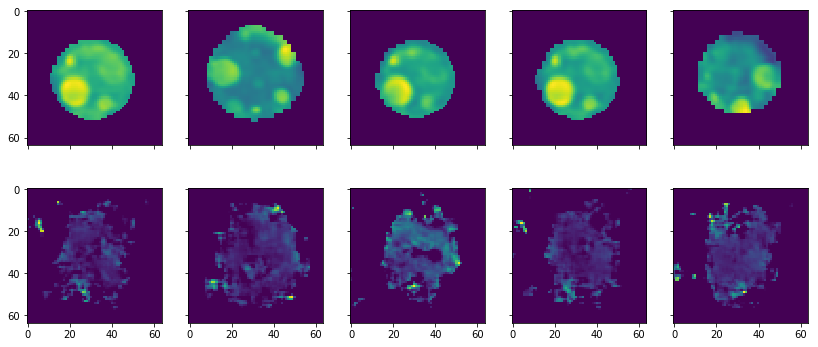

In [10]:
y_pred = model.predict(x_data)
# Test on Real Data
# Visualize Examples
N   = 5
row = 2
col = N

sidx = random.sample(range(len(y_pred)),N)

fig,axs = plt.subplots(row,col,sharex='col',sharey='row',figsize=(14,6))
for i,n in enumerate(sidx):
    axs[0,i%col].imshow(y_data[n])
    axs[1,i%col].imshow(y_pred[n])
    
#     mse = mean_squared_error(y_pred[n],y_data[n])
#     header = '{0}, mse={1:.04f}'.format(n,mse)
#     axs[0,i%col].set_title(header)